# Linear Regression by Kalman filter


The Kalman filter is a great tool!!

This is one of my favourite algorithms. It can be used in almost all practical applications in finance.   
And this is the reason I decided to write a notebook on the **applications of the Kalman filter to linear regression**.

I suggest the beginners in this area to have a look at [https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python).     
In my opinion this is one of the best interactive tutorials on Bayesian Filters ever written. 

## Contents
   - [Real market data](#sec1)
     - [Data Cleaning](#sec1.1) 
   - [Linear regression](#sec2)
   - [The Kalman filter](#sec3)

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import minimize
from IPython import display

<a id='sec1'></a>

# Real market data

I have collected some market time series from different sources and saved them in `historical_data.csv`, such that now we can play with them.

The tickers are:    
- STOCKS: `AAPL`-> Apple, `EXO.MI`-> Exor (FIAT,Ferrari,etc), `FB`-> Facebook, `GOOGL`-> Google, `UBS`-> UBS, 
- INDECES: `^GSPC`-> [S&P500](https://en.wikipedia.org/wiki/S%26P_500_Index), `^IXIC`-> [Nasdaq](https://en.wikipedia.org/wiki/NASDAQ_Composite), `^VIX`-> [VIX](https://en.wikipedia.org/wiki/VIX) (Implied Volatility of S&P500). 
- BOND:`^TNX`-> Yield 10Y US.  

In [2]:
filename = "data/" + "historical_data.csv"
data = pd.read_csv(filename, index_col="Date", parse_dates=True)
data.tail()

,AAPL,EXO.MI,FB,GOOGL,UBS,^GSPC,^IXIC,^TNX,^VIX
Date,,,,,,,,,
2019-10-28,249.050003,62.939999,189.399994,1288.979980,11.95,3039.419922,8325.990234,1.853,13.11
2019-10-29,243.289993,62.160000,189.309998,1260.660034,12.08,3036.889893,8276.849609,1.835,13.20
2019-10-30,243.259995,65.019997,188.250000,1260.699951,11.84,3046.770020,8303.980469,1.798,12.33
2019-10-31,248.759995,68.720001,191.649994,1258.800049,11.77,3037.560059,8292.360352,1.691,13.22
2019-11-01,255.820007,69.459999,193.619995,1272.250000,11.96,3066.909912,8386.400391,1.728,12.30


<a id='sec1.1'></a>
### Data cleaning

Data can contain NaNs, negative values, zeros and outliers. Let's have a look!

In [3]:
data[data.isna().any(axis=1)].tail()

,AAPL,EXO.MI,FB,GOOGL,UBS,^GSPC,^IXIC,^TNX,^VIX
Date,,,,,,,,,
2019-05-01,208.918625,NaN,193.029999,1173.319946,12.593584,2923.729980,8049.640137,2.511,14.80
2019-05-27,NaN,59.554962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-04,NaN,64.400002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-15,201.740005,NaN,182.589996,1169.319946,10.160000,2847.600098,7766.620117,1.529,21.18
2019-09-02,NaN,61.840000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
(data < 1e-2 ).any()

AAPL      False
EXO.MI    False
FB        False
GOOGL     False
UBS       False
^GSPC     False
^IXIC     False
^TNX      False
^VIX      False
dtype: bool

Fortunately there are no non-positive values, but there are several NaNs.     
Why?

There can be many reason, but in this case I think it is because of a different calendar (different countries have different holidays). 

##### How to solve this problem?
There are several possibilities:      
-   1)  We may remove the entire line     
-   2)  We may forward fill the missing values     
-   3)  We may backward fill the missing values     
-   4)  We may interpolate or estimate (e.g. regression) the missing values     

All these possibilities have advantages and disvantages. This is a delicate task, for more information see [Imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)).

First of all, let us select the two tickers for the regression analysis.

### Feel free to change the tickers in the next cell:

In [5]:
df = data[ ["GOOGL","^GSPC"] ]

In this analysis I choose the following:
- If in one day there is only one value missing, I use the second method i.e. **forward filling**. I can justify this choice by saying that if there are no prices, it means that the price didn't change.

- If in one day both values are missing, then I remove the entire line. (Probably the market was closed on that day) 

In [6]:
history_len = 1000                              # lenght of the time series 
df.sort_index(inplace=True, ascending =True)    # not necessary in general, but useful
df = df.dropna(axis=1, how='all')               # drops columns with all NaNs
df = df.dropna(axis=0, how='all')               # drops rows with at least one NaN
df = df[-history_len:]
df = df.ffill()                                 # Forward fill
print("Are there still some NaNs? "); df.isnull().any()

Are there still some NaNs? 


GOOGL    False
^GSPC    False
dtype: bool

If we call $S_t$ the price under consideration (stock, index, rate) at time $t$, we can work with three types of returns $X_t$:
- Total returns: 
$$ X_t = \frac{S_t}{S_{t-1}} $$
- Linear returns:
$$ X_t = \frac{S_t}{S_{t-1}} - 1 $$
- Logarithmic returns:
$$ X_t = \log \frac{S_t}{S_{t-1}} $$

For now, I prefer to work with log-returns.

In [7]:
returns = "log-returns"

if returns=="log-returns":
    ret = np.log( df/df.shift() )[1:]
elif returns=="linear-returns":  
    ret = df.pct_change()[1:]
elif returns=="total-returns":
    ret = df/df.shift()[1:]

##### Plot

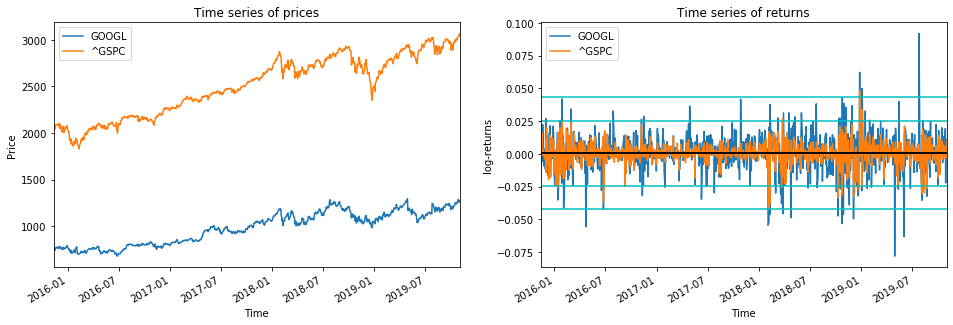

In [8]:
NOSD = 3               # Number Of Standard Deviations
mu = ret.mean()
sig = ret.std()
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

df.plot(ax=ax1)
ax1.set_title("Time series of prices"); ax1.set_xlabel("Time"); ax1.set_ylabel("Price")
ret.plot(ax=ax2)
ax2.set_title("Time series of returns"); ax2.set_xlabel("Time"); ax2.set_ylabel(returns)
ax2.plot(ret.index, len(ret)*[mu], color="k" )
ax2.plot(ret.index, len(ret)*[mu+NOSD*sig], color='c' )
ax2.plot(ret.index, len(ret)*[mu-NOSD*sig], color='c' )
plt.show()

### What about the outliers?

We can see that there are returns that are quite bigger than $3\sigma$ (three standard deviations).    
If we assume a Normal distribution for the returns, these outliers can create problems.

Wait a second...     
we calculated the standard deviation `ret.std()` using the data containing the ouliers!!     
It means that the value of the standard deviation is aslo affected by the outliers!!

The solution is to use [robust](https://en.wikipedia.org/wiki/Robust_statistics) estimators for the location and dispersion of the distribution, that work better in presence of outliers. 

Although there are several alternatives, I prefer to use the **median** and the [MAD](https://en.wikipedia.org/wiki/Median_absolute_deviation), which are more robust than the mean and standard deviation. In the standard deviation, the distances from the mean are squared, so large deviations are weighted more heavily, and thus outliers can heavily influence it. In the MAD instead, the deviations of a small number of outliers are irrelevant. 

As explained on [wiki](https://en.wikipedia.org/wiki/Median_absolute_deviation), in order to use the MAD as a consistent estimator of the standard deviation, we have to take 

$$ \sigma = k MAD $$

where under the assumption of Normal distribution, $k = 1.4826$.

In [9]:
median = ret.median()
MAD = ret.mad()
sig_robust = MAD*1.4826
print("STD DEV: \n", sig); print(""); print("Robust STD DEV: \n", sig_robust); 

STD DEV: 
 GOOGL    0.014242
^GSPC    0.008324
dtype: float64

Robust STD DEV: 
 GOOGL    0.014794
^GSPC    0.008357
dtype: float64


In [10]:
outliers = ret[ret[ np.abs(ret-median)>NOSD*sig_robust ].any(axis=1)]     # outliers
dret = ret.drop(outliers.index)                                           # series of returns without outliers

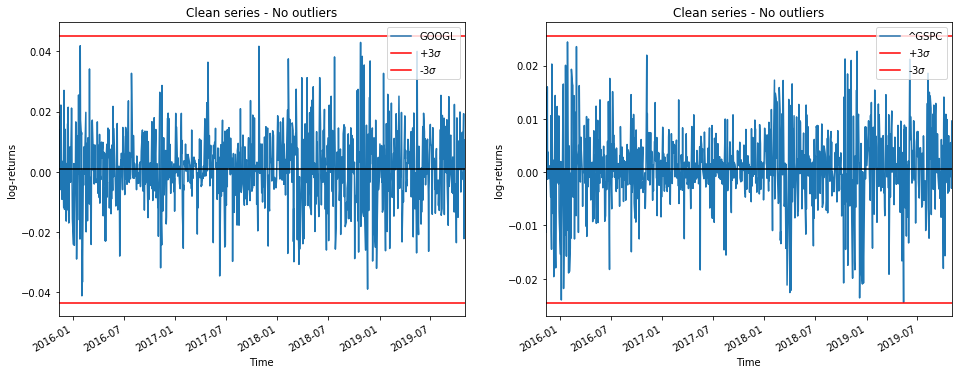

In [11]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122) 

for ax, col in zip([ax1,ax2], dret.columns):
    dret[col].plot(ax=ax)
    ax.set_title("Clean series - No outliers"); ax.set_xlabel("Time"); ax.set_ylabel(returns)
    ax.plot(dret.index, len(dret)*[median[col]], color="k" )
    ax.plot(dret.index, len(dret)*[median[col]+NOSD*sig_robust[col]], color='r', label="+3$\sigma$" )
    ax.plot(dret.index, len(dret)*[median[col]-NOSD*sig_robust[col]], color='r', label="-3$\sigma$" )
    ax.legend(loc="upper right")
plt.show()

In [12]:
print("We have reduced the initial DIRTY series of returns of size {} to the \
new CLEAN series of size {}.".format(len(ret),len(dret)))

We have reduced the initial DIRTY series of returns of size 999 to the new CLEAN series of size 974.


<a id='sec2'></a>
# Linear regression

Let me recall some well known notions about [linear regression](https://en.wikipedia.org/wiki/Linear_regression).     The linear model is:

$$ Y = \alpha + \beta X + \epsilon $$

where 
- X is the predictor variable
- Y is the response variable
- $\epsilon$ is the error such that $Std[\epsilon]= \sigma$ and $Cov[\epsilon,X]=0$. 

Since the Kalman filter assumes normal errors, we can also assume that $\epsilon \sim \mathcal{N}(0,\sigma^2)$.

The parameters $\alpha$ and $\beta$ can be estimated by:

$$ \mathbb{E}[Y] = \alpha + \beta \mathbb{E}[X]  \quad \Rightarrow \quad \alpha = \mathbb{E}[Y] - \beta \mathbb{E}[X]$$

and, using the bilinear property of the Covariance:

$$ Cov[X,Y] = Cov[ X, \alpha + \beta X + \epsilon ] = \beta Var[X] $$

$$ \beta = \frac{Cov[X,Y]}{Var[X]} $$

If we have some observations $x_i$, we can use the linear regression as a model for the respose variables only (which are random) $Y_i = \alpha + \beta x_i + \epsilon_i$, where the $\epsilon_i$ are uncorrelated. The expectation $\mathbb{E}[Y_i]$ is intended as a conditional expectation $\mathbb{E}[Y_i|x_i]$.     

If we have two sets of data $y_i$ and $x_i$ for $1 \leq i \leq n$, where $y_i$ are the realizations of $Y_i$, we call:
$\bar x = \frac{1}{n} \sum_{i=1}^n x_i$ and $\bar y = \frac{1}{n} \sum_{i=1}^n y_i$.      
We also define 

$$S_{xx} = \sum_{i=1}^n (x_i - \bar x)^2 \quad S_{yy} = \sum_{i=1}^n (y_i - \bar y)^2  \quad S_{xy} = \sum_{i=1}^n (x_i - \bar x)(y_i - \bar y) $$  

The estimator $\hat \beta$ and $\hat \alpha$ for $\beta$ and $\alpha$ are: 

$$ \hat \beta = \frac{S_{xy}}{S_{xx}} \quad \quad \hat \alpha = \bar y - \beta \bar x $$

These estimators are the **least squares** estimators. Ther are also the **MLE estimators** and the **BLUE** (best linear unbiased estimators).     
Of course $\mathbb{E}[\hat \beta]=\beta$ and $\mathbb{E}[\hat \alpha]=\alpha$ (they are unbiased). We also have:

$$ Var[\hat \beta] = \frac{\sigma^2}{S_{xx}} \quad Var[\hat \alpha] = \frac{\sigma^2}{n S_{xx}}\sum_{i=1}^n x_i^2 $$

and under the assumption of Normal errors, the estimators are also Normal distributed. (the square root of the variance is the standard error of $\hat \alpha$ or $\hat \beta$)       
The residual estimator is $\hat \epsilon_i = y_i - \hat \alpha - \hat \beta x_i$. We can define the estimator for $\sigma$.
- MLE (biased)  
$$ \hat \sigma^2 = \frac{1}{n} \sum_{i=1}^n \epsilon_i^2 $$
it has $\mathbb{E}[\hat \sigma] = \frac{n-2}{n} \sigma^2 $.
- Unbiased version:
$$ S^2 = \frac{n}{n-2}\hat \sigma^2 = \frac{1}{n-2} \sum_{i=1}^n \epsilon_i^2 $$
Under the normal assumption of errors, it is distributed as $\frac{(n-2)S^2}{\sigma^2} \sim \chi^2_{n-2}$.

Confidence intervals can be obtained from the statistics:

$$ \frac{\hat \alpha - \alpha}{ S \sqrt{(\sum_{i=1}^n x_i^2)/nS_{xx}} } \sim t_{n-2} \quad and \quad  
\frac{\hat \beta - \beta}{ S \sqrt{S_{xx}} } \sim t_{n-2} $$

where I replaced the parameter $\sigma$ with its unbiased estimator $S$. For a short (but complete) description of confidence intervals you can have a look at the notebook **1.2**.      
For more info see [CI for linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression#Confidence_intervals), or the deeper presentation in Chapter 11.3 of [1].

Last, let us recall (with no proof) that if we call $\hat y_i = \hat \alpha + \hat \beta x_i$, then

$$ S_{yy} = \sum_{i=1}^n (y_i - \bar y)^2 =\; \sum_{i=1}^n (\hat y_i - \bar y)^2 + \sum_{i=1}^n (y_i - \hat y_i)^2  
=\; \frac{S^2_{xy}}{S_{xx}} + \sum_{i=1}^n \hat \epsilon_i^2 .$$

We can define the **coefficient of determination $r^2$** such that $0 \leq r^2 \leq 1$, as

\begin{align*}
r^2 &=\; \frac{\sum_{i=1}^n (\hat y_i - \bar y)^2}{\sum_{i=1}^n (y_i - \bar y)^2} =\; \frac{S_{xy}^2}{S_{xx}S_{yy}} \\
&=\; 1 - \frac{\sum_{i=1}^n (\hat \epsilon_i)^2}{\sum_{i=1}^n (y_i - \bar y)^2}.
\end{align*}

In [14]:
X = dret[dret.columns[1]]
Y = dret[dret.columns[0]]
print("In our regression Y is {} and X is {}".format(dret.columns[0],dret.columns[1]) )

In our regression Y is GOOGL and X is ^GSPC


In [51]:
b_ss, a_ss, r_ss, _, std_err_ss = ss.linregress(X,Y)
print("We can use one of the many python functions:\nbeta: {0:6f}, alpha: {1:6f}, R2: {2:6f}, \
standard error: {3:6f}.".format(b_ss, a_ss, r_ss**2, std_err_ss))

beta_tot_OLS = np.cov(X,Y,ddof=1)[0,1] / np.var(X,ddof=1)
alpha_tot_OLS = np.mean(Y) - beta_tot_OLS * np.mean(X)
res = Y - beta_tot_OLS * X - alpha_tot_OLS
std_eps_OLS = np.std(res, ddof=2) 
print("\nOr I can estimate by myself:\nbeta: {}, alpha: {}, sigma: {}".format(beta_tot_OLS, 
                                                                             alpha_tot_OLS, std_eps_OLS))

We can use one of the many python functions:
beta: 1.161800, alpha: 0.000297, R2: 0.474801, standard error: 0.039193.

Or I can estimate by myself:
beta: 1.1617997206407595, alpha: 0.000297277734251804, sigma: 0.008757049085402898


Come on....Let's compute everything: (with the help of the scalar product between vectors `@`)

In [46]:
n = len(X)
x_mean = np.mean(X); y_mean = np.mean(Y)
Sxx = (X-x_mean) @ (X-x_mean)
Syy = (Y-y_mean) @ (Y-y_mean)
Sxy = (X-x_mean) @ (Y-y_mean)
beta_hat = Sxy/Sxx; alpha_hat = y_mean - beta_hat * x_mean    # beta and alpha
print("beta: {} and alpha: {}".format(beta_hat,alpha_hat))
epsilon = Y - beta_hat * X - alpha_hat             # residuals
S2 = epsilon @ epsilon / (n-2); S = np.sqrt(S2)    # unbiased estimator
print("sigma: {}".format(S))
var_beta = S2/Sxx                 # variance of beta 
var_alpha = (X@X) * S2/(Sxx * n)  # variance of alpha 
s_b = np.sqrt(var_beta)           # standard error for beta
s_a = np.sqrt(var_alpha)          # standard error for alpha
R2 = Sxy**2 / (Sxx*Syy)           
print("Standard Error for beta: ", s_b); print("R squared: {}".format(R2))
CI_b = ss.t.interval(0.95, n-2, loc=beta_hat, scale=s_b );  b_up = CI_b[0]; b_down = CI_b[1]
CI_a = ss.t.interval(0.95, n-2, loc=alpha_hat, scale=s_a )
print("Confidence intervals for beta: ", CI_b); print("Confidence intervals for alpha: ", CI_a)

beta: 1.1617997206407595 and alpha: 0.000297277734251804
sigma: 0.008757049085402896
Standard Error for beta:  0.03919264085592505
R squared: 0.4748007016211966
Confidence intervals for beta:  (1.0848877850257101, 1.238711656255809)
Confidence intervals for alpha:  (-0.0002567777632213888, 0.0008513332317249967)


The intercept $\alpha$ is (always) almost zero. Therefore it is not relevant for the future analysis.   

##### Plot:

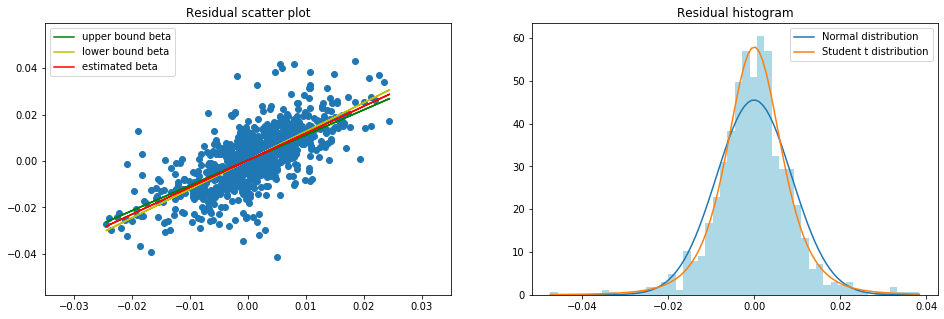

In [65]:
x = np.linspace(res.min(),res.max(),100)     # res are the residuals

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.scatter(X, Y); ax1.set_title("Residual scatter plot") 
ax1.plot(X, alpha_hat + b_up*X, color="g", label="upper bound beta")
ax1.plot(X, alpha_hat + b_down*X, color="y", label="lower bound beta")
ax1.plot(X, alpha_hat + beta_hat*X, color="red", label="estimated beta"); ax1.legend(loc="upper left")
ax2.plot(x, ss.norm.pdf(x,0,S), label="Normal distribution")
params = ss.t.fit(res)
ax2.plot(x, ss.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax2.hist(res, bins=50, density=True, facecolor="LightBlue") 
ax2.legend(); ax2.set_title("Residual histogram"); plt.show()

The first thing we notice is that the Normal fit is not so good.     
The distribution is better described by a Student t distribution with 

In [67]:
print("Degrees of freedom of fitted t distribution: ", params[0])

Degrees of freedom of fitted t distribution:  4.2454945618103554


However, it is much easier to mantain the Normal assumption, because it permits to use confidence intervals and... also... the Kalman filter!!

<a id='sec3'></a>
# The Kalman filter

I do not have the space to explain the [Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter). I assume the reader already has a general knowledge, or at least some intuition about it. (otherwise read the tutorial mentioned at the top of the page) 

Important things to remember:  the KF (Kalman Filter) assumes a linear dynamics and Normally distributed errors.    
The main formulas, taken from [here](https://en.wikipedia.org/wiki/Kalman_filter#Underlying_dynamical_system_model), are:



## References

[1] Casella, George and Berger, Roger. (2001) "Statistical inference" Duxbury Advanced Series 